In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('data/input/non_standardized_X_train.csv', index_col=0)
y_train = pd.read_csv('data/input/y_train.csv', index_col=0)

In [3]:
X_test = pd.read_csv('data/input/non_standardized_X_test.csv', index_col=0)

In [4]:
np.random.seed(42)

### 10-fold Cross-Validation

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [6]:
def kfold_mse(X, y, model, k=10):
    kf = KFold(n_splits=k)
    mses = []
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train['sales']) # Avoid deprecation warning
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(y_pred, y_val['sales']))
    return mses

Since scikit-learn's implementation of random forest has many tunable hyperparameters, we shall concern only `ccp_alpha`, `max_depths` and `min_smples_leaf` in this project. `n_estimators`, `max_features`, `min_samples_split` are fixed to 1000, 'sqrt' and 0.01. Actually, using more estimators is better as random forest does not overfit. 1000 is a good number to stay within computational time limits.

In [7]:
ccp_alphas = [0.0, 0.01, 0.05, 1.0]
min_samples_leafs = [1, 3, 5, 10, 20]
max_depths = [None, 3, 5, 10]

In [8]:
from sklearn.ensemble import RandomForestRegressor

In [9]:
best_mses = []
best_avg_score = 1e9
best_ccp_alpha = None
best_depth = None
best_min_samples_leaf = None
for ccp_alpha in ccp_alphas:
    for depth in max_depths:
        for ml in min_samples_leafs:
            model = RandomForestRegressor(ccp_alpha=ccp_alpha, max_depth=depth, min_samples_leaf=ml, random_state=42, min_samples_split=0.01, max_features='sqrt', n_estimators=1000)
            mses = kfold_mse(X_train, y_train, model)
            if np.mean(mses) < best_avg_score:
                best_avg_score = np.mean(mses)
                best_ccp_alpha = ccp_alpha
                best_depth = depth
                best_min_samples_leaf = ml
                best_mses = mses
            print(f'ccp_alpha: {ccp_alpha}, max_depth: {depth}, min_samples_leaf: {ml}, avg_mse: {np.mean(mses)}')

ccp_alpha: 0.0, max_depth: None, min_samples_leaf: 1, avg_mse: 365.24331544435046
ccp_alpha: 0.0, max_depth: None, min_samples_leaf: 3, avg_mse: 374.8475289796194
ccp_alpha: 0.0, max_depth: None, min_samples_leaf: 5, avg_mse: 384.89707437320084
ccp_alpha: 0.0, max_depth: None, min_samples_leaf: 10, avg_mse: 405.92169861208447
ccp_alpha: 0.0, max_depth: None, min_samples_leaf: 20, avg_mse: 445.2677226432141
ccp_alpha: 0.0, max_depth: 3, min_samples_leaf: 1, avg_mse: 571.460341418425
ccp_alpha: 0.0, max_depth: 3, min_samples_leaf: 3, avg_mse: 564.7353484539369
ccp_alpha: 0.0, max_depth: 3, min_samples_leaf: 5, avg_mse: 562.9526703439284
ccp_alpha: 0.0, max_depth: 3, min_samples_leaf: 10, avg_mse: 562.2620302270838
ccp_alpha: 0.0, max_depth: 3, min_samples_leaf: 20, avg_mse: 563.5872170348958
ccp_alpha: 0.0, max_depth: 5, min_samples_leaf: 1, avg_mse: 504.6070947051655
ccp_alpha: 0.0, max_depth: 5, min_samples_leaf: 3, avg_mse: 495.8912421356716
ccp_alpha: 0.0, max_depth: 5, min_samples_l

### In-sample analysis

In [10]:
print(f'best ccp_alpha: {best_ccp_alpha}, best max_depth: {best_depth}, best min_samples_leaf: {best_min_samples_leaf}, best avg_mse: {np.mean(best_mses)}')

best ccp_alpha: 0.05, best max_depth: None, best min_samples_leaf: 1, best avg_mse: 365.2070711524956


In [11]:
cv_df = pd.DataFrame(best_mses, columns=['Cross-Validation MSE'])
cv_df

,Cross-Validation MSE
0,303.485832
1,152.007012
2,422.142951
3,273.933731
4,342.340879
5,154.461765
6,571.642974
7,342.053972
8,963.654224
9,126.347371


In [12]:
cv_df.to_csv('data/output/cv/rf.csv')

### Model fitting

After finding best parameters (not applicable to LR but useful for other models), we fit the model on the entire training set and predict on the test set. Also, we collect residuals to prepare for inventory decision making.

In [13]:
rf = RandomForestRegressor(ccp_alpha=best_ccp_alpha, max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, random_state=42, min_samples_split=0.01, max_features='sqrt', n_estimators=1000)
rf.fit(X_train, y_train['sales']) # Avoid deprecation warning
residuals = y_train['sales'] - rf.predict(X_train)

In [14]:
output_df = X_test.copy()

In [15]:
output_df['sales'] = rf.predict(X_test)

### Inventory decision
As sales data come from a natural process, we shall not assume it is distributed in any particular model. Hence, we shall use an empirical distribution to make our inventory decision. 

In [16]:
residuals.describe()

count    2211.000000
mean       -0.053561
std        14.613265
min       -27.025531
25%        -4.562280
50%        -2.266459
75%         0.755225
max       311.846175
Name: sales, dtype: float64

For visualization of Empirical CDF, we use the `statsmodels` package:

In [17]:
from statsmodels.distributions.empirical_distribution import ECDF

In [18]:
ecdf = ECDF(residuals)

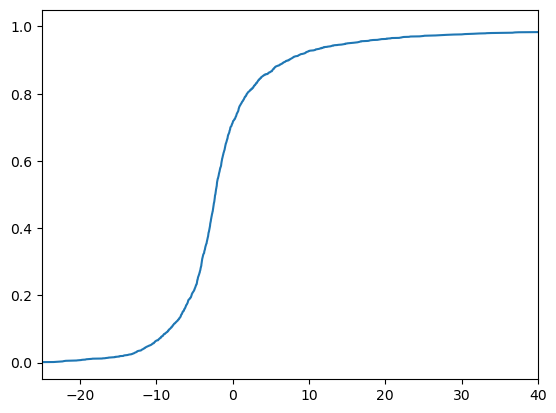

In [19]:
plt.plot(ecdf.x, ecdf.y)
plt.xlim(-25, 40)
plt.show()

Sparsity is not a concern since we have a large sample size. Therefore, we can use interpolation to obtain ppf. To get the empirical ppf, we can use scipy's `interp1d` to get the inverse function:

In [20]:
from scipy.interpolate import interp1d

In [21]:
eppf = interp1d(ecdf.y, ecdf.x)

Calculate the critical fractile

In [22]:
price = 20
cost = 12
salvage = 8
over = cost - salvage
under = price - cost
critical_fractile = under / (over + under)
critical_fractile

0.6666666666666666

We offset our predictions for the test datasets by the $eppf(critical\_fractile)$ to get the optimal inventory level.

In [23]:
output_df['inventory'] = eppf(critical_fractile) + output_df['sales']

In [24]:
output_df[['sales', 'inventory']].head()

,sales,inventory
0,33.776872,33.104664
1,58.733008,58.060800
2,23.254895,22.582686
3,26.088089,25.415881
4,10.394399,9.722191


In [25]:
output_df.to_csv('data/output/predictions/rf.csv')